# Open Images V4 Data Preparation Utility For YOLOv3

This module extracts images from the Open Images V4 dataset that contain selected classes, generating a corresponding .txt or .xml file for each image as per the YOLO and PASCALVOC annotation formats respectively and the necessary metadata files.

You will need these external libraries:
    1. awscli
    2. pandas
    3. pascal_voc_writer
    4. pillow
    5. seaborn
    6. tqdm
    
You require the following meta files, located in one directory:
    1. class_desc.csv
    2. train_anns.csv
    3. train_imgs.csv
    4. valid_anns.csv
    5. valid_imgs.csv
    
    * automatically downloaded if not exists
    
Subsequently, specify the source and destination paths accordingly, in the dictionaries:
    1. src
    2. dst

Finally, indicate the output annotation format by setting the variable ```fmt``` as either:
    1. "YOLO" or 
    2. "PASCALVOC"

Your selected classes are stored as a list of class descriptions (case-sensitive) - add to or remove from it as needed. Optionally, you can limit the number of training and validation images copied by setting:
    1. limit
    2. n
    
Both training and validation images will be copied into a folder named ```custom```, and the generated metadata files are:
    1. custom.names - contains class descriptions
    2. train.txt    - contains relative paths from darknet.exe to every trainin image
    3. valid.txt    - contains relative paths from darknet.exe to every validation image
    
    i.e. data/custom/XXX.jpg
    
Your directory tree should look like this:

```
+-- darknet
|   +-- cfg
|   |   +-- custom.data
|   |   ...
|   +-- data
|   |   +-- custom
|   |   |   +-- XXX.jpg
|   |   |   +-- XXX.txt
|   |   |   +-- YYY.jpg
|   |   |   +-- YYY.txt
|   |   |   ...
|   |   +-- custom.names
|   |   +-- meta
|   |   |   +-- class_desc.csv
|   |   |   +-- train_anns.csv
|   |   |   +-- train_imgs.csv
|   |   |   +-- valid_anns.csv
|   |   |   +-- valid_imgs.csv
|   |   +-- train.txt
|   |   +-- validation.txt
|   ...
...
```

In [8]:
from pascal_voc_writer import Writer
from PIL import Image
from tqdm import tqdm
from shutil import copyfile
import matplotlib.pyplot as plt
import os
import pandas as pd
import requests
import seaborn as sns
sns.set_style("darkgrid")
import subprocess

In [9]:
classes = [
    "Hat",
    "Handgun",
    # "Human face",
    "Jacket",
    "Knife",
    # "Person",
    "Rifle",
    "Sunglasses",
]

src = {"train": "data/train", 
       "validation": "data/validation", 
       "meta": "data/meta"}
dst = "data"
fmt = "YOLO"
limit = {"train": False, 
         "validation": False}
n = {"train": 10000, 
     "validation": 1000}

AWS = "aws s3 --no-sign-request cp s3://open-images-dataset"
URLS = {"class_desc": "https://storage.googleapis.com/openimages/2018_04/class-descriptions-boxable.csv", 
        "train_anns": "https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv", 
        "train_imgs": "https://storage.googleapis.com/openimages/2018_04/train/train-images-boxable-with-rotation.csv", 
        "valid_anns": "https://storage.googleapis.com/openimages/2018_04/validation/validation-annotations-bbox.csv", 
        "valid_imgs": "https://storage.googleapis.com/openimages/2018_04/validation/validation-images-with-rotation.csv"}

In [10]:
class OpenImagesUtility():
    def __init__(self, classes, src, dst, fmt, limit, n):
        self.src = src
        self.dst = dst
        self.fmt = fmt
        self.limit = limit
        self.n = n
        
        self.mk_dst_dirs()
        self.dl_openimages_metas()
            
        self.class_desc = pd.read_csv("{}/class_desc.csv".format(self.src["meta"]), header=None)
        self.class_desc.columns = ["LabelName", "Description"]
        label_names = [self.class_desc[self.class_desc["Description"] == c]["LabelName"].values[0]
                       for c in classes]
        """
        select LabelName, Description
        from   class_desc
        where  LabelName in label_names
        """
        self.class_desc = (self.class_desc[self.class_desc["LabelName"].isin(label_names)][["LabelName", "Description"]]
                           .sort_values(["Description"]))
        self.class_desc = self.class_desc.reset_index(drop=True)
        print("Total Classes: {}".format(self.class_desc.shape[0]))
        
        train_anns = pd.read_csv("{}/train_anns.csv".format(self.src["meta"]))
        """
        select *
        from   train_anns join class_desc
               on LabelName
        """
        train_anns = (pd.merge(train_anns, self.class_desc, on="LabelName")
                      .sort_values(["ImageID"]))
        print("Total Training Annotations: {}".format(train_anns.shape[0]))

        train_imgs = pd.read_csv("{}/train_imgs.csv".format(self.src["meta"]))
        """
        select *
        from   train_imgs join (select distinct ImageID from train_anns) 
               on ImageID
        """
        train_imgs = (pd.merge(train_imgs, pd.DataFrame(train_anns["ImageID"].unique(), columns=["ImageID"]), on="ImageID")
                      .sort_values(["ImageID"]))
        print("Total Training Images: {}".format(train_imgs.shape[0]))
        
        valid_anns = pd.read_csv("{}/valid_anns.csv".format(self.src["meta"]))
        """
        select *
        from   valid_anns join class_desc
               on LabelName
        """
        valid_anns = (pd.merge(valid_anns, self.class_desc, on="LabelName")
                      .sort_values(["ImageID"]))
        print("Total Validation Annotations: {}".format(valid_anns.shape[0]))
        
        valid_imgs = pd.read_csv("{}/valid_imgs.csv".format(self.src["meta"]))
        """
        select *
        from   valid_imgs join (select distinct ImageID from valid_anns) 
               on ImageID
        """
        valid_imgs = (pd.merge(valid_imgs, pd.DataFrame(valid_anns["ImageID"].unique(), columns=["ImageID"]), on="ImageID")
                      .sort_values(["ImageID"]))
        print("Total Validation Images: {}".format(valid_imgs.shape[0]))
        
        self.anns = {"train": train_anns, 
                     "validation": valid_anns}
        self.imgs = {"train": train_imgs, 
                     "validation": valid_imgs}
        self.counts = {desc: 0 for desc in self.class_desc["Description"]}
    
    def _add_counts(self, anns):
        for _, r in anns.iterrows():
            self.counts[self.get_label_desc(r["LabelName"])] += 1
            
    def _to_yolo_format(self, label_name, x_min, x_max, y_min, y_max):
        """
        Converts annotations from PASCALVOC to YOLO format.
        """
        label_idx = self.get_label_idx(label_name)
        x_mid = (x_min + x_max) / 2
        y_mid = (y_min + y_max) / 2
        width = x_max - x_min
        height = y_max - y_min
        return "{} {} {} {} {}".format(label_idx, x_mid, y_mid, width, height)

    def _mk_anns_txt(self, anns, folder_path, img_id):
        """
        Create annotations .txt file in YOLO format.
        """
        with open("{}/{}.txt".format(folder_path, img_id), "w+") as file:    
            file.write("\n".join([self._to_yolo_format(r["LabelName"], r["XMin"], r["XMax"], r["YMin"], r["YMax"]) 
                                  for _, r in anns.iterrows()]))
            file.close()

    def _mk_anns_xml(self, anns, folder_path, img_id):
        """
        Create annotations .xml file in PASCALVOC format.
        """
        img = Image.open("{}/{}.jpg".format(folder_path, img_id))
        width, height = img.size
        writer = Writer(folder_path, width, height)
        for _, r in anns.iterrows():
            label_desc = self.get_label_desc(r["LabelName"])
            x_min = round(r["XMin"] * width)
            x_max = round(r["XMax"] * width)
            y_min = round(r["YMin"] * height)
            y_max = round(r["YMax"] * height)
            writer.addObject(label_desc, x_min, y_min, x_max, y_max)
        writer.save("{}/{}.xml".format(folder_path, img_id))
            
    def _mk_anns_file(self, anns, folder_path, img_id):
        """
        Create annotations file in specified format.
        """
        if self.fmt == "YOLO":
            self._mk_anns_txt(anns, folder_path, img_id)
        elif self.fmt == "PASCALVOC":
            self._mk_anns_xml(anns, folder_path, img_id)
        else:
            raise ValueError("Invalid annotation format")
        self._add_counts(anns)
                
    def get_label_desc(self, label_name):
        return self.class_desc[self.class_desc["LabelName"] == label_name]["Description"].values[0]

    def get_label_idx(self, label_name):
        return self.class_desc[self.class_desc["LabelName"] == label_name].index[0]
    
    def plt_anns_dist(self, mode):
        """
        Displays a horizontal bar graph of the number of annotations per selected class.
        
        Input(s):
        mode (str) - either "train" or "validation" 
        """
        dist = (self.anns[mode]
                .groupby(["LabelName"])
                .size()
                .reset_index(name="Count")
                .sort_values(["Count"]))
        dist["LabelName"] = dist["LabelName"].apply(self.get_label_desc)
        plt.barh(y=dist["LabelName"], width=dist["Count"])
        plt.show()
        
    def dl_openimages_metas(self):
        for file_name, url in URLS.items():
            file_path = "{}/{}.csv".format(self.src["meta"], file_name)
            if not os.path.exists(file_path):
                r = requests.get(url, allow_redirects=True, stream=True)
                file_size = int(r.headers['Content-Length'])
                with open(file_path, "wb") as file:
                    chunk_size = 1024
                    total = int(file_size / chunk_size)
                    for chunk in tqdm(r.iter_content(chunk_size=chunk_size), total=total, unit="KB", leave=True):
                        file.write(chunk)
                    file.close()
        
    def mk_dst_dirs(self):
        """
        Create destination directories if not exists.
        """
        if not os.path.exists(self.dst): 
            os.mkdir(self.dst)
        if not os.path.exists("{}/meta".format(self.dst)):
            os.mkdir("{}/meta".format(self.dst))
        if not os.path.exists("{}/custom".format(self.dst)):
            os.mkdir("{}/custom".format(self.dst))
            
    def mk_yolo_metas(self):
        """
        Create necessary YOLO metadata files:
        .names - contains all class descriptions, 1 per line
        .data  - ?
        """
        with open("{}/custom.names".format(self.dst), "w+") as file:
            file.write("\n".join(self.class_desc["Description"].tolist()))
            file.close()
        with open("cfg/custom.data", "w+") as file:
            file.write("classes={}" \
                       "\ntrain=data/train.txt" \
                       "\nvalid=data/validation.txt" \
                       "\nnames=data/custom.names" \
                       "\nbackup=backup"
                       .format(self.class_desc.shape[0]))
            file.close()
        
    def prep(self, mode):
        """
        Copy image from source to destination and create corresponding annotations file in destination directory.
        If local directory is not specified or image is missing from it, image is copied from CVDF's AWS S3 bucket.
        If image already exists in destination directory, copy is skipped but a new annotation file will be created.
        
        Input(s):
        mode (str) - either "train" or "validation"
        """
        if not self.limit[mode]: 
            self.n[mode] = self.imgs[mode].shape[0] 
        paths = []
        with tqdm(total=self.n[mode]) as pbar:
            for _, r in self.imgs[mode].iterrows():
                if self.limit[mode] and len(paths) == self.n[mode]: 
                    break
                img_src = "{}/{}.jpg".format(self.src[mode], r["ImageID"])
                img_dst = "{}/custom/{}.jpg".format(self.dst, r["ImageID"])
                if not os.path.exists(img_dst):
                    if not os.path.exists(img_src):
                        cmd = "{}/{}/{}.jpg {}/custom".format(AWS, mode, r["ImageID"], self.dst)
                        s3 = subprocess.run(cmd.split(), check=True, universal_newlines=True)
                    else:
                        copyfile(img_src, img_dst)
                self._mk_anns_file(self.anns[mode][self.anns[mode]["ImageID"] == r["ImageID"]],
                                   "{}/custom".format(self.dst), 
                                   r["ImageID"])
                paths.append("data/custom/{}.jpg".format(r["ImageID"]))
                pbar.update()
        with open("{}/{}.txt".format(self.dst, mode), "w+") as txt:
            txt.write("\n".join(paths))
            txt.close()
        
    def start(self):
        self.mk_yolo_metas()
        self.prep("train")
        self.prep("validation")

In [11]:
utility = OpenImagesUtility(classes, src, dst, fmt, limit, n)

11KB [00:00, 122.84KB/s]              
1166049KB [02:22, 8163.55KB/s]                             
623446KB [01:14, 8402.28KB/s]                            
16674KB [00:01, 13642.71KB/s]                           
14889KB [00:01, 14324.31KB/s]                           


Total Classes: 6
Total Training Annotations: 67315
Total Training Images: 38050
Total Validation Annotations: 662
Total Validation Images: 475


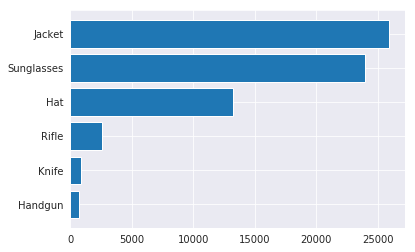

In [5]:
utility.plt_anns_dist("train")

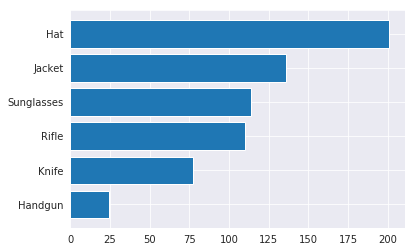

In [6]:
utility.plt_anns_dist("validation")

In [10]:
utility.start()

100%|██████████| 475/475 [00:14<00:00, 32.31it/s]
